# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

### Import Data

In [1]:
import pandas as pd

# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/LambdaSchool/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import data into a DataFrame named df
df = pd.read_json(data_url, lines=True)
# df = pd.DataFrame(df)
df.head()

# raise NotImplementedError()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [2]:
# Visible Testing
assert isinstance(df, pd.DataFrame), 'df is not a DataFrame. Did you import the data into df?'
assert df.shape[0] == 10000, 'DataFrame df has the wrong number of rows.'

## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [3]:
# Import NLP libraries
import spacy
from spacy.tokenizer import Tokenizer

# Optional: consider using spacy in your function
# if you do use this pre-trained model, YOU MUST USE THE SMALL VERSION en_core_web_sm
# if you don't already have the small version downloaded, you'll have to download it
# this is due to limited computational resources on CodeGrader
# if you don't plan on using this model in the SC, simply comment it out 
nlp = spacy.load('en_core_web_sm')

In [4]:
# Initialize the Tokenizer
tokenizer = Tokenizer(nlp.vocab)

def tokenize(doc):
    """
    This function will take a document
      and return a list of tokens for each document
    :param doc: Can be a single document or a DataFrame with multiple docs
    :return: A list of token for each document
    """
    tokens = []  # empty list to hold tokens

    # Iterate through all docs in the dataframe using a pipeline
    for doc in tokenizer.pipe(doc, batch_size=250):
        doc_tokens = []  # Temp empty list to hold tokens for each doc

        # Iterate through each token within the doc
        for token in doc:
            if (token.is_stop != True) & (  # if it is not a default stop word
                token.is_punct != True) & (  # if it is not punctuation
                token.is_space != True):  # if it is not an extra whitespace
                # Add to the end of the temp list and lowercase all tokens
                doc_tokens.append(token.text.lower())

        # Add all the doc tokens to the tokens list
        tokens.append(doc_tokens)

    # Return the list of tokens for all docs in the dataframe
    return tokens

# raise NotImplementedError()

# Add a tokenized column to my dataframe
df['tokens'] = tokenize(df['text'])
df['tokens'].head()

0    [beware!!!, fake,, fake,, fake....we, small, b...
1    [came, lunch, togo., service, quick., staff, f...
2    [i've, vegas, dozens, times, stepped, foot, ci...
3    [went, night, closed, street, party..., best, ...
4    [3.5, 4, stars, bad, price,, $12.99, lunch,, s...
Name: tokens, dtype: object

In [5]:
'''Testing'''
assert isinstance(tokenize(df.sample(n=1)["text"].iloc[0]), list), "Make sure your tokenizer function accepts a single document and returns a list of tokens!"

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, use `NearestNeighbors` model for this. 

In [6]:
# Create a vector representation of the reviews 
# Name that doc-term matrix "dtm"

# Import TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the vectorizer object
tfidf = TfidfVectorizer(stop_words='english',
                        ngram_range=(1, 3),
                        max_df=0.6,
                        min_df=5,
                        max_features=5000)

# Fit the vectorizer
dtm_fit = tfidf.fit_transform(df.text)

# Turn into a Document Term Matrix
dtm = pd.DataFrame(dtm_fit.todense(), columns=tfidf.get_feature_names())

# Check my work
print(dtm.shape)
dtm.sample(5)

# raise NotImplementedError()

(10000, 5000)


,00,000,00pm,10,10 10,10 15,10 30,10 mins,10 minutes,10 years,...,young,younger,yuck,yum,yummy,zero,zero stars,zone,zucchini,était
8989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Create and fit a NearestNeighbors model named "nn"
from sklearn.neighbors import NearestNeighbors

# Fit on the DTM dataframe
nn = NearestNeighbors(n_neighbors=10,
                      algorithm='kd_tree',
                      leaf_size=8,
                      n_jobs=10)
nn.fit(dtm)

# raise NotImplementedError()

NearestNeighbors(algorithm='kd_tree', leaf_size=8, metric='minkowski',
                 metric_params=None, n_jobs=10, n_neighbors=10, p=2,
                 radius=1.0)

In [8]:
'''Testing.'''
assert nn.__module__ == 'sklearn.neighbors._unsupervised', ' nn is not a NearestNeighbors instance.'
assert nn.n_neighbors == 10, 'nn has the wrong value for n_neighbors'

In [9]:
# Create a fake review and find the 10 most similar reviews
fake = ["""
    I ate lunch here with my best friend and my husband.
    The soup was ice cold and the service was horrible.
    The waitress made me feel like we were just a burden on her,
    whenever she actually came to the table.
    The prices are really low though.
    This is one of those places where you get what you pay for.
    You could not pay me enough to come back here again!
"""]

# Vectorize my fake review
my_review = tfidf.transform(fake)

# Run my KNN on my vectorized fake review
nn.kneighbors(my_review.todense())

# raise NotImplementedError()


(array([[1.        , 1.        , 1.24862091, 1.25107865, 1.26698043,
         1.26870021, 1.27037035, 1.27291029, 1.27428966, 1.27807897]]),
 array([[6204, 6311, 9617, 7235, 4281, 9266, 6008,  889, 2114, 7340]],
       dtype=int64))

In [10]:
# Look at the 10 closest matched reviews to my fake review
print(f'Closest Review to mine:\n{df.text.loc[6204]}\n\n')
print(f'2nd closest Review to mine:\n{df.text.loc[6311]}\n\n')
print(f'3rd closest Review to mine:\n{df.text.loc[9617]}\n\n')
print(f'4th closest Review to mine:\n{df.text.loc[7235]}\n\n')
print(f'5th closest Review to mine:\n{df.text.loc[4281]}\n\n')
print(f'6th closest Review to mine:\n{df.text.loc[9266]}\n\n')
print(f'7th closest Review to mine:\n{df.text.loc[6008]}\n\n')
print(f'8th closest Review to mine:\n{df.text.loc[889]}\n\n')
print(f'9th closest Review to mine:\n{df.text.loc[2114]}\n\n')
print(f'10th closest Review to mine:\n{df.text.loc[7340]}\n\n')


Closest Review to mine:
旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。
質問にも丁寧に答えてくれましたし、日本人の方も日本語が話せる方も居て、とても綺麗で居心地のいいお店でした。 
ネイルはちはるさんと言う綺麗な方が丁寧にしてくれとても気に入りました。
予定になかったまつ毛エクステもお願いし、日本ではまだあまりないブラウンカラーのエクステをしてもらい、とても気に入りました。
また是非マッサージなどで伺いたいと思います。


2nd closest Review to mine:
天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用心製作，包含擺盤精緻、佐料衛生，夏日想開胃，這是一個不錯的選擇，服務人員也很敬業，以後會常常來


3rd closest Review to mine:
The service was horrible. I had to ask the manager to find out about our food since it was more than an hour wait from the time we ordered. Our waitress did not update us to why there was a delay and did not refill our drinks. I know that since I don't drink alcohol I do not get looked in on as frequently but an hour without service?  Then the food was brought out by the manager cold. Also miraculously the waitress came to the table when the manager brought our food. I can count on one hand how many times I have not tipped in my 48 years since high school paying for my meals. Last night was one of th

What patterns I see on my matches:
  - The first 2 reviews that are closest to mine look like they are in Chinese or something. I do not understand how that happened when I am using the english vocab for tokenizing and vectorizing the data.
  - The 3rd closest review to mine was extremely similar to mine.
  - The 4th closest review was similar to mine on the service and food but not the price.
  - The 5th closest review was nothing at all like my review, it was positive, while mine was very negative. That does not fall in line with the rest of the matches.
  - The 6th closest review is only talking about the service which was horrible and that does match but nothing about food or price.
  - The 7th closest review was not even for a restaurant, it seems to be for a massage place of some sort.
  - The 8th closest review aligns pretty close to my review. Disgusted with service and food but no mention of price.
  - The 9th closest review is a very negative review and matches mine almost perfectly.
  - The final recommend review doesn't really seem to align with anything in my review, and I don't understand why.
  - I would say out of the 8 reviews that were in English, and I could read, only 5 related closely to mine. It is possible that the first 2 did also, but can not read them. Out of the ones that did not relate to mine at all, 2 of them were positive reviews, while mine was negative all around, and 1 wasn't even for a restaurant.

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a pipeline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier.
    - Use that pipeline to estimate a model to predict the `stars` feature (i.e. the labels). 
    - Use the Pipeline to predict a star rating for your fake review from Part 2. 



2. Create a parameter dict including `one parameter for the vectorizer` and `one parameter for the model`. 
    - Include 2 to 3 possible values for each parameter
    - **Use `n_jobs` = 1** 
    - Due to limited computational resources on CodeGrader `DO NOT INCLUDE ADDITIONAL PARAMETERS OR VALUES PLEASE.`
    
    
3. Tune the entire pipeline with a GridSearch
    - Name your GridSearch object as `gs`

In [11]:
# Using these functions from explore_data.py but
#   have to add the function here to pass the autograder
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.

    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'stop_words': 'english',  # Added stop words to default kwargs
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(14,6))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()

X: (10000,), y: (10000,)
Median words per sample: 79.0
Samples to words ratio: 126.58227848101266


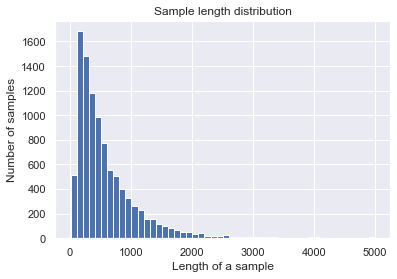

In [12]:
# Imports
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Other plotting imports
# import eli5  # Have to comment out to pass autograder
import seaborn as sns
sns.set()

# Define my feature to use for predictions and target
X = df.text
y = df.stars

# Look at the shape of X and y
print(f'X: {X.shape}, y: {y.shape}')

# Get the median words per sample
med_words = get_num_words_per_sample(X)
print(f'Median words per sample: {med_words}')

# Get the ratio of number of samples / the median words per sample
sw_ratio = len(X) / med_words
print(f'Samples to words ratio: {sw_ratio}')

# Plot the length of characters in the data
plot_sample_length_distribution(X)

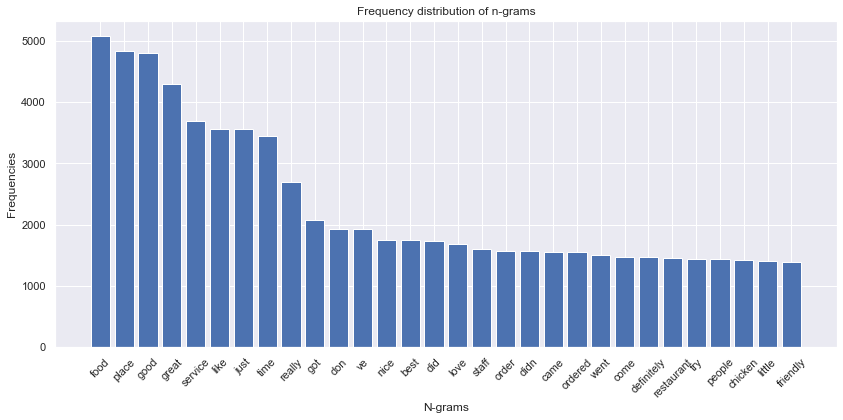

In [13]:
# Plot the top 30 n_grams
plot_frequency_distribution_of_ngrams(X, ngram_range=(1, 3), num_ngrams=30)

In [14]:
# Initialize a vectorizer with basic parameters
vect = TfidfVectorizer(stop_words='english')

# Initialize a classifer with basic parameters
clf = LinearSVC()

# Define my pipeline
pipe = Pipeline([
    ('vect', vect),
    ('clf', clf)
])

# Parameters to run through grid search
params = {
    'vect__max_df': (0.3, 0.5, 0.6),
    'vect__min_df': (3, 5, 6, 9),
    'vect__max_features': (2500, 5000),
    'vect__ngram_range': ((1, 2), (1, 3)),
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.01, 0.1, 0.3, 0.6)
}

# Name the gridsearch instance "gs"
# Instantiate the grid search cv and fit it
gs = GridSearchCV(pipe, params, cv=5, n_jobs=10, verbose=1)
gs.fit(X, y)

# raise NotImplementedError()

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   21.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  7.7min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed: 12.0min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 17.3min
[Parallel(n_jobs=10)]: Done 1920 out of 1920 | elapsed: 18.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [15]:
# Visible Testing
prediction = gs.predict(["I wish dogs knew how to speak English."])[0]
assert prediction in df.stars.values, 'You gs object should be able to accept raw text within a list. Did you include a vectorizer in your pipeline?'

In [16]:
# Get the best score from my grid search
print(f'Grid Search Best Score: {gs.best_score_}\n')

# Look at the best parameters from the grid search
print(f'Grid Search Best Parameters:\n{gs.best_params_}')

Grid Search Best Score: 0.6186

Grid Search Best Parameters:
{'clf__C': 0.1, 'clf__penalty': 'l2', 'vect__max_df': 0.5, 'vect__max_features': 2500, 'vect__min_df': 9, 'vect__ngram_range': (1, 2)}


In [17]:
# Assign my best model parameters
best_mod = gs.best_estimator_
vect = best_mod.named_steps['vect']
clf = best_mod.named_steps['clf']

# Evaluate on my fake review
my_review_pred = best_mod.predict(fake)
print(f'Prediction of how many stars my review would be: {my_review_pred}')

Prediction of how many stars my review would be: [1]


In [18]:
# Explain what the model learned about each class
# eli5.show_weights(clf, vec=vect, top=30)
# Have to comment out to pass autograder

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Set num_topics to `5`
    - Name your LDA model `lda`
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

When you construct your LDA model, it should look like this: 

```python
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

```

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [19]:
from gensim import corpora
# Due to limited computational resources on CodeGrader, use the non-multicore version of LDA 
from gensim.models.ldamodel import LdaModel
import gensim
import re

In [20]:
# Create a dictionary using a method from the gensim library
id2word = corpora.Dictionary(df.tokens)

# Look at the length of the words
len(id2word.keys())

60537

In [21]:
# Remove the extreme values
id2word.filter_extremes(no_below=2, no_above=0.9)

# Look at the length of the words now
len(id2word.keys())

23510

In [22]:
# Create a BOW representation of the entire corpus
corpus = [id2word.doc2bow(text) for text in df.tokens]

### 1. Estimate a LDA topic model of the review tex

In [23]:
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               num_topics=5)


# raise NotImplementedError()

#### Testing

In [24]:
# Visible Testing
assert lda.get_topics().shape[0] == 5, 'Did your model complete its training? Did you set num_topics to 5?'

#### 2. Create 1-2 visualizations of the results

In [25]:
# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

# Create a pyLDAvis visualization
pyLDAvis.enable_notebook()
py_vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(py_vis)
# raise NotImplementedError()


#### 3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

Based on my visualization, it appears that I could do with better tokenization. I noticed that there are a few words that could have been added to the stop words list to improve my predictability. I can see that the largest topic is topic 1 at 30.3% of the tokens, which appears to be related to the positive reviews of restaurants. All the other topics appear to be related to the positive reviews as well.

Topic 2 appears to be more related to spa type of businesses, not restaurants. Topic 3 appears to be more related to hotels for tourist. While topic 4 appears to be talking about local businesses mostly. Last but not least, topic 5 appears to be reviews of automotive businesses mostly.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)

C:\Users\sahmj\anaconda3\envs\u4-s1-NLP\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
